# Control

Convex optimization can be used to solve many problems that arise in control.
In this example we show how to solve such a problem using Convex.jl.
We have a system with a state $x_t\in {\bf R}^n$ that varies over the time steps $t=0,\ldots,T$, and inputs or actions $u_t\in {\bf R}^m$ we can use at each time step to affect the state.
For example, $x_t$ might be the position and velocity of a rocket and $u_t$ the output of the rocket's thrusters.
We model the evolution of the state as a linear dynamical system, i.e.,

$$ x_{t+1} = Ax_t + Bu_t $$

where $A \in {\bf R}^{n\times n}$ and $B \in {\bf R}^{n\times m}$ are known matrices.

Our goal is to find the optimal actions $u_0,\ldots,u_{T-1}$ by solving the optimization problems

\begin{array}{ll} \mbox{minimize} & \sum_{t=0}^{T-1} \ell (x_t,u_t) + \ell_T(x_T)\\
\mbox{subject to} & x_{t+1} = Ax_t + Bu_t\\%, \quad t=0, \ldots, T-1\\
& (x_t,u_t) \in \mathcal C, \quad x_T\in \mathcal C_T,
%, \quad \quad t=0, \ldots, T
\end{array}

where $\ell: {\bf R}^n \times {\bf R}^m\to {\bf R}$ is the stage cost, $\ell_T$ is the terminal cost,
$\mathcal C$ is the state/action constraints, and $\mathcal C_T$ is the terminal constraint.
The optimization problem is convex if the costs and constraints are convex.


In [36]:
# Generate data for control problem
using LinearAlgebra
using Random
Random.seed!(1234);
n = 8;
m = 2;
T = 50;
alpha = 0.3;
beta = 1;
A = I + alpha*randn(n,n);
B = randn(n,m);
x_0 = beta*randn(n);

In [37]:
# Form and solve control problem
using Convex
using SCS

x = Variable(n,T+1);
u = Variable(m, T);

cost = 0;
for t in 1:T
    cost += sumsquares(x[:,t+1]) + sumsquares(u[:,t]);
end

problem = minimize(cost)

for t in 1:T
    problem.constraints += [x[:,t+1]==A*x[:,t]+B*u[:,t], 
                            norm(u[:,t], Inf)<=1];
end

problem.constraints += [x[:,T+1]==0, x[:,1]==x_0];
solve!(problem, SCS.Optimizer(verbose=1));


----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 6067, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 859, constraints m = 1767
Cones:	primal zero / dual free vars: 417
	linear vars: 450
	soc vars: 900, soc blks: 200
Setup time: 8.15e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.03e+19  7.86e+18  1.00e+00 -6.78e+21  2.02e+18  5.22e+21  8.12e-04 
   100| 1.76e-01  1.79e-01  6.55e-03  4.16e+01  4.11e+01  5.52e-16  5.97e-02 
   200| 9.45e-02  9.53e-02  1.31e

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/Arash/.julia/packages/Convex/SRJjA/src/solution.jl:250


In [38]:
problem.status

ALMOST_OPTIMAL::TerminationStatusCode = 7

In [39]:
problem.optval

74.44710064578786

We display the results using a 4-stack of $x_1$, $x_2$, $u_1$ and $u_2$ below. Notice that $u_t$ is bounded (i.e., $\|u_t\|_\infty \leq 1$),
suggesting that the input constraint is meaningful.

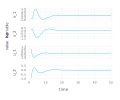

In [40]:
using Gadfly, DataFrames
Gadfly.set_default_plot_size(12cm, 10cm)

x_eval = evaluate(x);
u_eval = evaluate(u);

df = DataFrame(time=repeat(Array(1:T), 4), 
                value=[x_eval[1,1:T]; x_eval[2,1:T]; u_eval[1,:]; u_eval[2,:]], 
                variable=[fill("x_1", T); fill("x_2", T); fill("u_1", T); fill("u_2", T)]);

p = plot(df, x=:time, y=:value, ygroup=:variable, Geom.subplot_grid(Geom.line, free_y_axis=true))